# NonNegative ALS with just Stars

https://spark.apache.org/docs/latest/ml-collaborative-filtering.html

In [122]:
import pandas as pd
import numpy as np

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS

# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()

In [196]:
# import src_2.evaluate as evaluate

# # Convert a Pandas DF to a Spark DF
# spark_df = spark.createDataFrame(pandas_df) 

# # Convert a Spark DF to a Pandas DF
# pandas_df = spark_df.toPandas()

In [2]:
train_starred = pd.read_pickle('data/pickled/train_starred.pkl')
test_starred = pd.read_pickle('data/pickled/test_starred.pkl')

In [3]:
spark_train_stars_df = spark.createDataFrame(train_starred)
spark_test_stars_df = spark.createDataFrame(test_starred)

#### check spark dataframes

In [4]:
spark_train_stars_df.show()

+--------+-------+-------------------+---------------+----+--------------------+--------+-------+
| repo_id|user_id|         created_at|          login|type|                 url|language|starred|
+--------+-------+-------------------+---------------+----+--------------------+--------+-------+
|   12031| 889397|1202439272000000000|       cdcarter| USR|https://api.githu...|    Ruby|      1|
|52574448| 889397|1202442872000000000|       cdcarter| USR|https://api.githu...|      \N|      1|
|   12031|  17898|1203008090000000000|        gnufied| USR|https://api.githu...|    Ruby|      1|
|   12031|  25789|1203568157000000000|          Sutto| USR|https://api.githu...|    Ruby|      1|
|   12031|  10942|1203910346000000000|       tarcieri| USR|https://api.githu...|    Ruby|      1|
|   12031|  35126|1204050466000000000|         cypher| USR|https://api.githu...|    Ruby|      1|
|40916741| 401456|1204169012000000000|           dsrw| USR|https://api.githu...|   Shell|      1|
|   12031|  60568|12

In [5]:
spark_test_stars_df.show()

+--------+--------+-------------------+-----------------+----+--------------------+----------+-------+
| repo_id| user_id|         created_at|            login|type|                 url|  language|starred|
+--------+--------+-------------------+-----------------+----+--------------------+----------+-------+
|55567488| 6694284|1485492399000000000|          CaiJiJi| USR|https://api.githu...|    Python|      1|
|    1282|13665131|1485492672000000000|         tarvos21| USR|https://api.githu...|    Python|      1|
|   16356| 6806774|1485492818000000000|       acro5piano| USR|https://api.githu...|       PHP|      1|
|12651428|   11997|1485492868000000000|           alias1| USR|https://api.githu...|    Python|      1|
|  394885| 9279104|1485493232000000000|        nilsdeppe| USR|https://api.githu...|    Python|      1|
|29629404| 2060726|1485493578000000000|           Patola| USR|https://api.githu...|         C|      1|
|   38701|12092442|1485493937000000000|         buhuipao| USR|https://api

#### create ALS recommender model

In [199]:
als_model = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='starred',
    implicitPrefs=True,
    nonnegative=True,    
    regParam=0.1,
    rank=10
    ) 

In [200]:
recommender = als_model.fit(spark_train_stars_df)
predictions = recommender.transform(spark_test_stars_df)

In [203]:
pred_df = predictions.toPandas()
pred_df.sort_values('prediction', ascending=False)

,repo_id,user_id,created_at,login,type,url,language,starred,prediction
138835,28557277,3011143,1496672996000000000,a5a,USR,https://api.github.com/repos/tensorflow/tensor...,C++,1,1.102072
137380,28557277,63262,1485843715000000000,jiessie,USR,https://api.github.com/repos/tensorflow/tensor...,C++,1,0.989328
162723,14098,13164165,1495363594000000000,nycatelos,USR,https://api.github.com/repos/radare/radare2,C,1,0.973631
120918,9664377,1733408,1497235274000000000,MaGuowei,USR,https://api.github.com/repos/tornadoweb/tornado,Python,1,0.970888
138107,28557277,4262703,1486886331000000000,jtlowery,USR,https://api.github.com/repos/tensorflow/tensor...,C++,1,0.957618
38342,424503,6075868,1489650656000000000,tzpBingo,USR,https://api.github.com/repos/soimort/you-get,Python,1,0.941444
11631,28686845,2531148,1492411569000000000,chinakook,USR,https://api.github.com/repos/aymericdamien/Ten...,Jupyter Notebook,1,0.923364
162705,14098,3362790,1490736627000000000,hslatman,USR,https://api.github.com/repos/radare/radare2,C,1,0.921127
138601,28557277,8681879,1488822736000000000,htadg,USR,https://api.github.com/repos/tensorflow/tensor...,C++,1,0.910691
128267,10170583,9255737,1487596797000000000,xeoneux,USR,https://api.github.com/repos/google/cadvisor,Go,1,0.907960


# NonNegative ALS with Stars & Forks (implicit weighted actions)

https://spark.apache.org/docs/latest/ml-collaborative-filtering.html

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
# from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()

In [92]:
forks_and_stars = pd.read_pickle('data/pickled/forks_and_stars.pkl')
forks_and_stars.columns

Index([u'user_id', u'repo_id', u'forked', u'created_at', u'starred',
       u'interest_rank'],
      dtype='object')

#### since I didn't pickle train and test data for this run using both Star and Forks, create my timestamp ordered train-test split

In [93]:
def ordered_train_test_split(df, order_by, test_size=0.33):
    '''
    Takes a pandas dataframe and returns a train and test dataset ordered by the 
    column name passed to order_by and sliced up to the test_size
    INPUT:
    df: pandas df
    order_by: list or str of column names
    test_size: float percentage of df to use as test set
    OUTPUT:
    train: pandas dataframe
    test: pandas dataframe
    '''
    upto = int(df.shape[0] * (1 - test_size))
    df = df.sort_values(by=order_by, axis=0)
    train = df.iloc[:upto,:]
    test = df.iloc[upto:,:]
    return train, test

In [94]:
train_forks_stars, test_forks_stars = ordered_train_test_split(
    forks_and_stars, order_by=['created_at'], test_size=0.33)

In [95]:
print train_forks_stars.shape
print test_forks_stars.shape

(681076, 6)
(335456, 6)


#### create spark dataframes for train/test data

In [96]:
sp_train_forks_stars = spark.createDataFrame(train_forks_stars)
sp_test_forks_stars = spark.createDataFrame(test_forks_stars)

In [97]:
model = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='interest_rank',
    implicitPrefs=True,
    nonnegative=True,    
    maxIter=10, 
    alpha=0.01
    ) 

In [98]:
recommender = model.fit(sp_train_forks_stars)
predictions = recommender.transform(sp_test_forks_stars)

In [99]:
pred_df = predictions.toPandas()

In [100]:
pred_df.sort_values(['user_id','prediction'], ascending=False)

,user_id,repo_id,forked,created_at,starred,interest_rank,prediction
17451,36791462,68425726,2.0,1498863052000000000,0.0,2.0,NaN
3042,36791293,20711751,2.0,1498861756000000000,1.0,3.0,NaN
93307,36791293,20711251,0.0,1498861751000000000,1.0,1.0,NaN
24524,36791076,38393576,2.0,1498860785000000000,0.0,2.0,NaN
141628,36790822,24958152,2.0,1498858442000000000,0.0,2.0,NaN
324068,36790741,63547354,2.0,1498860145000000000,0.0,2.0,NaN
320981,36790642,51568068,2.0,1498857388000000000,0.0,2.0,NaN
296748,36790336,13057459,2.0,1498855585000000000,0.0,2.0,NaN
255195,36789893,30334789,2.0,1498853132000000000,0.0,2.0,NaN
183068,36789460,27683242,2.0,1498850815000000000,0.0,2.0,NaN


# NonNegative ALS with Stars & Owned Repos (implicit weighted actions)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS, ALSModel
# The following is only for working with RDDs
# from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()

In [3]:
own_and_star = pd.read_pickle('data/pickled/new_subset_own_and_star.pkl')
own_and_star.columns
own_and_star.head(5)

,repo_id,user_id,forked_from_repo_id,owned,created_at,starred,interest_rank
0,2,4,0.0,4.0,2009-06-10 20:32:21,0.0,4.0
1,3,23,0.0,4.0,2011-02-19 02:58:42,0.0,4.0
2,5,28,6.0,4.0,2012-03-12 17:48:19,0.0,4.0
3,6,31,0.0,4.0,2010-11-18 23:17:00,0.0,4.0
4,10,67,0.0,4.0,2011-02-01 08:11:48,2.0,6.0


#### since I didn't pickle train and test data for this run using both Star and Forks, create my timestamp ordered train-test split

In [32]:
def ordered_train_test_split(df, order_by, test_size=0.33):
    '''
    Takes a pandas dataframe and returns a train and test dataset ordered by the 
    column name passed to order_by and sliced up to the test_size
    INPUT:
    df: pandas df
    order_by: list or str of column names
    test_size: float percentage of df to use as test set
    OUTPUT:
    train: pandas dataframe
    test: pandas dataframe
    '''
    upto = int(df.shape[0] * (1 - test_size))
    df = df.sort_values(by=order_by, axis=0)
    train = df.iloc[:upto,:]
    test = df.iloc[upto:,:]
    return train, test

In [33]:
train_owns_stars, test_owns_stars = ordered_train_test_split(
    own_and_star, order_by=['created_at'], test_size=0.33)

In [34]:
print train_owns_stars.shape
print test_owns_stars.shape

(2372137, 7)
(1168367, 7)


In [37]:
train_owns_stars[['user_id', 'repo_id', 'interest_rank']].to_csv('data/new_subset_data/train_data.csv', sep=',', index=False)
test_owns_stars[['user_id', 'repo_id', 'interest_rank']].to_csv('data/new_subset_data/test_data.csv', sep=',', index=False)

#### create spark dataframes for train/test data

In [7]:
sp_train_owns_stars = spark.createDataFrame(train_owns_stars)
sp_test_owns_stars = spark.createDataFrame(test_owns_stars)


In [8]:
sp_entire_dataset = spark.createDataFrame(own_and_star)

In [14]:
model = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='interest_rank',
    nonnegative=True,    
    regParam=1.0,
    rank=25,
    maxIter=15,
    alpha=10
    ) 

In [15]:
# Fit recommender model
recommenderall = model.fit(sp_entire_dataset)
recommender = model.fit(sp_train_owns_stars)

In [24]:
recommender.save("/home/ubuntu/PROJECT/github-collaborator/data/models/ALSmodel")

In [27]:
recommender = ALSModel.load("/home/ubuntu/PROJECT/github-collaborator/data/models/ALSmodel")

In [28]:
#Make some predicitons from test set
rawPredictions = recommender.transform(sp_test_owns_stars)

In [29]:
pred_df = rawPredictions.toPandas()

In [31]:
pred_df.sort_values('prediction', ascending=False).head()

,repo_id,user_id,forked_from_repo_id,owned,created_at,starred,interest_rank,prediction
1005690,10901621,1090484,0.0,0.0,1470778280000000000,2.0,2.0,5.270817
18743,35591075,1090484,0.0,0.0,1470777948000000000,2.0,2.0,5.253704
1113354,29215456,1090484,0.0,0.0,1470777972000000000,2.0,2.0,4.967988
673441,35535175,1789129,0.0,0.0,1484395063000000000,2.0,2.0,4.780213
673473,35535175,11007330,0.0,0.0,1481011878000000000,2.0,2.0,4.684288


### random

In [220]:
null_predictions = sum(pred_df['prediction'].isnull())


In [310]:
pred_df.sort_values(['prediction'], ascending=False).iloc[10000:10100,:]

,repo_id,user_id,forked_from_repo_id,owned,created_at,starred,interest_rank,prediction
365020,18521760,249979,0,0.0,1493129173000000000,1.0,1.0,0.229794
327702,13407509,154877,0,0.0,1496342869000000000,1.0,1.0,0.229787
108722,31810056,497349,0,0.0,1497853711000000000,1.0,1.0,0.229773
249095,43786,5723,0,0.0,1490296951000000000,1.0,1.0,0.229768
95065,10495335,216188,0,0.0,1483220551000000000,1.0,1.0,0.229762
40976,5219,11670696,0,0.0,1487564281000000000,1.0,1.0,0.229748
287290,19911836,67696,0,0.0,1489368728000000000,1.0,1.0,0.229747
204809,12831,3944360,0,0.0,1485890558000000000,1.0,1.0,0.229737
327658,13407509,1484460,0,0.0,1497385450000000000,1.0,1.0,0.229736
23239,28686845,156029,0,0.0,1487498621000000000,1.0,1.0,0.229733


In [227]:
non_null = pred_df.loc[pred_df['prediction'].isnull() == False]
non_null = non_null['prediction']


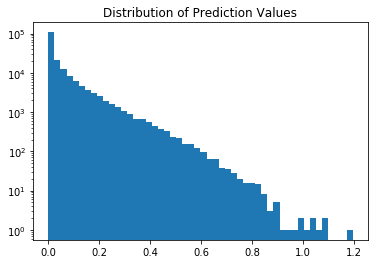

In [229]:
plt.hist(non_null, bins=50)
plt.title("Distribution of Prediction Values")
plt.yscale('log');

In [230]:
# Predictions where repo-user has just a OWNS relationship
(pred_df.loc[(pred_df.interest_rank == 4) & (~pred_df.prediction.isnull())]).sort_values(
    'prediction', ascending=False)

,repo_id,user_id,forked_from_repo_id,owned,created_at,starred,interest_rank,prediction
245113,52878664,2216159,0,4.0,1481755233000000000,0.0,4.0,0.016881
123447,53531959,599582,0,4.0,1482796812000000000,0.0,4.0,0.001790
28325,56322797,10433,0,4.0,1486246603000000000,0.0,4.0,0.001627
182690,56341200,2606940,0,4.0,1486310145000000000,0.0,4.0,0.000544
285944,53389749,9652,0,4.0,1482540899000000000,0.0,4.0,0.000397
21771,56725833,10269343,0,4.0,1486185254000000000,0.0,4.0,0.000061
75564,52688610,596995,0,4.0,1481277537000000000,0.0,4.0,0.000050
64988,52668800,265517,0,4.0,1481575228000000000,0.0,4.0,0.000041
114402,56507651,7830654,0,4.0,1486218712000000000,0.0,4.0,0.000008
31448,56531417,693322,0,4.0,1486351589000000000,0.0,4.0,0.000000


In [131]:
(pred_df.loc[pred_df.user_id == 9652]).sort_values('prediction', ascending=False)

,repo_id,user_id,forked_from_repo_id,owned,created_at,starred,interest_rank,prediction
285944,53389749,9652,0,4.0,1482540899000000000,0.0,4.0,0.844856


In [231]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366344 entries, 0 to 366343
Data columns (total 8 columns):
repo_id                366344 non-null int64
user_id                366344 non-null int64
forked_from_repo_id    366344 non-null int64
owned                  366344 non-null float64
created_at             366344 non-null int64
starred                366344 non-null float64
interest_rank          366344 non-null float64
prediction             181703 non-null float64
dtypes: float64(4), int64(4)
memory usage: 22.4 MB


#### RMSE won't really work for implicit data since there are no target values you're trying to hit, just a strength the model believes the user would have an interest in the repo

In [35]:
from pyspark.ml.evaluation import RegressionEvaluator

In [36]:
rawPredictions = spark.createDataFrame(pred_df.dropna(axis=0))

In [37]:
predictions = rawPredictions\
    .withColumn("interest_rank", rawPredictions.interest_rank.cast("double"))\
    .withColumn("prediction", rawPredictions.prediction.cast("double"))
evaluator =\
    RegressionEvaluator(metricName="rmse", labelCol="interest_rank", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.739859499114


#### See what predictions come from all users-repos

The 'prediction' Spark ALS returns for user-repo combos (using implicit ratings) is the level of confidence the model has that the user would interact the repo.

So to make repo recommendations for a user, I need to run .transform() on a spark dataframe of that user against every repo I have.

## Create little dataframe of random user-repo mappings to use for predictions for recommendations

In [77]:
repos = pd.read_pickle('data/pickled/new_subset_repos.pkl')
users = pd.read_pickle('data/pickled/new_subset_users.pkl')

In [78]:
def random_user_against_repos(users_df, repos_df):
    user = users_df['id'].iloc[np.random.choice(users_df.shape[0])]
    prediction_df = pd.DataFrame(repos_df['id'])
    prediction_df['user_id'] = user
    prediction_df = prediction_df.rename(columns={'id':'repo_id'})
    return prediction_df

In [79]:
df = random_user_against_repos(users, repos)
df.head(3)

,repo_id,user_id
0,2,2517863
1,3,2517863
2,5,2517863


In [42]:
df['user_id'] = 7271611

### Make predictions and order by top recommendations

In [80]:
test_user = spark.createDataFrame(df)
predictions_user = recommenderall.transform(test_user)
predictions_user.toPandas().sort_values('prediction', ascending=False).head(10)

,repo_id,user_id,prediction
93936,49060702,2517863,6.738385
187945,32144805,2517863,6.467147
1048752,13745548,2517863,6.444273
650636,10908073,2517863,6.444273
797744,1098428,2517863,6.444273
823944,21509204,2517863,6.423631
320297,47416195,2517863,6.423631
504512,43189759,2517863,6.380615
1100746,3293712,2517863,6.366199
570326,51926377,2517863,6.335629


In [45]:
repos[repos.id == 1530831]

,id,url,owner_id,name,language,created_at,forked_from
92625,1530831,https://api.github.com/repos/mon-key/magit,6077,magit,Emacs Lisp,2011-09-13 03:40:40,26454


In [44]:
users[users.id == 7271611]

,id,login,company,created_at,type,country_code,state,city,location
50004,7271611,ayadlin,\N,2015-03-03 19:39:51,USR,\N,\N,\N,\N


## Define a metric for evaluating recommender

In [2]:
def mean_percentage_ranking(model, test_df):
    '''
    Metric for evaluating recommender model quality.
    For the starred and owned repos for a user in the test set,
    how far down the top recommended repos does it take to capture them.
    
    Something like 
    1. group test_df by user_id to get a list of repo_ids they actually interacted with
    2. sort the predictions_df by top recommendations for a user
    3. count how far down the predictions_df until all the test_df repo_ids for a user occur
    4. divide the num of test_df repo_ids by the count down to find all repo_ids, and append that
        ratio to a list
    5. Take the mean of the list of ratios
    '''
    test_df = spark.toPandas()
    user_set = set(test_df.user_id)
    repo_set = set(test_df.repo_id)
    
    for user in user_set:
        # Make predictions for user against all test repos
        user_df = pd.DataFrame(test_df.repo_id)
        user_df['user_id'] = user
        predictions = model.transform(user_df)
        # Sort predictions so recommendations are top
        predictions = spark.toPandas(predictions)
        predictions = predictions.sort_values('prediction', ascending=False)
        print predictions.head(3)
    

In [ ]:
mean_percentage_ranking(recommender, sp_test_owns_stars)

In [34]:
from evaluator.validate import *

saving calculated NDCGs to  /run/user/1000/jupyter/kernel-879d2760-f372-43ee-8744-1194a97a5741.json


IOError: [Errno 2] No such file or directory: '-f'

## Use SVD matrix factorization in Surprise library

In [109]:
from surprise.dataset import Reader
from surprise import SVD
from surprise import Dataset
from surprise import evaluate, print_perf

In [112]:
own_and_star = pd.read_pickle('data/pickled/new_subset_own_and_star.pkl')

In [113]:
own_and_star = own_and_star[['user_id','repo_id','interest_rank','created_at']]
own_and_star.to_csv('data/new_subset_data/own_and_star.csv', index=False)

In [114]:
ownstar = pd.read_csv('data/new_subset_data/own_and_star.csv')
ownstar.info()
ownstar.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540504 entries, 0 to 3540503
Data columns (total 4 columns):
user_id          int64
repo_id          int64
interest_rank    float64
created_at       object
dtypes: float64(1), int64(2), object(1)
memory usage: 108.0+ MB


Index([u'user_id', u'repo_id', u'interest_rank', u'created_at'], dtype='object')

In [120]:
# path to dataset file
file_path = os.path.expanduser('data/new_subset_data/own_and_star.csv')

# As we're loading a custom dataset, we need to define a reader. In the
# movielens-100k dataset, each line has the following format:
# 'user item rating timestamp', separated by '\t' characters.
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(2,6))

data = Dataset.load_from_file(file_path, reader=reader)
data.split(n_folds=3)

In [119]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Evaluate performances of our algorithm on the dataset.
perf = evaluate(algo, data, measures=['RMSE', 'MAE'])

print_perf(perf)

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8011
MAE:  0.5721
------------
Fold 2
RMSE: 0.8014
MAE:  0.5728
------------
Fold 3
RMSE: 0.7999
MAE:  0.5716
------------
Fold 4
RMSE: 0.8015
MAE:  0.5728
------------
Fold 5
RMSE: 0.8011
MAE:  0.5728
------------
------------
Mean RMSE: 0.8010
Mean MAE : 0.5724
------------
------------
        Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    
MAE     0.5721  0.5728  0.5716  0.5728  0.5728  0.5724  
RMSE    0.8011  0.8014  0.7999  0.8015  0.8011  0.8010  


### this did not work since dataset is too large. Took all night and wa still running in morning

In [ ]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# # First train an SVD algorithm on my repo dataset
# data = Dataset.load_from_file(file_path, reader=reader)
# data.split(n_folds=3)

trainset = data.build_full_trainset()
algo = SVD()
algo.train(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

## GridSearch in Spark

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()

In [12]:
als = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='interest_rank',
    nonnegative=True,
    maxIter=10)

# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for hashingTF.numFeatures and 2 values for lr.regParam,
# this grid will have 3 x 2 = 6 parameter settings for CrossValidator to choose from.
paramGrid = ParamGridBuilder() \ 
    .addGrid(als.regParam, [0.1, 0.01]) \
    .addGrid(als.rank, [10, 15, 20, 25, 30, 35]) \
    .addGrid(als.alpha, [0.1, 1.0, 5, 10, 20, 40]) \
    .build()

crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(metricName="rmse", 
                                                        labelCol="interest_rank", 
                                                        predictionCol="prediction"),
                          numFolds=3)  

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(sp_train_owns_stars)

SyntaxError: unexpected character after line continuation character (<ipython-input-12-f1416e2d9324>, line 12)

## Turn Dataframe into RDD and run RankingMetric NDCG

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
# from pyspark.sql import SparkSession
# from pyspark.ml.recommendation import ALS, ALSModel

# The following is only for working with RDDs
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark.mllib.evaluation import RankingMetrics

# Setup a SparkSession
# spark = SparkSession.builder.getOrCreate()

sc = spark.sparkContext

NameError: name 'spark' is not defined

In [2]:
!head 'data/new_subset_data/train_data.csv'

user_id,repo_id,interest_rank
9236,16462,4.0
44511,12031,4.0
9236,72450,4.0
1570,225335,4.0
1563,105156,4.0
213711,1035597,4.0
1563,5413,4.0
9236,2236530,4.0
78115,25384,4.0


In [49]:
# Read in the ratings data for training set
train = sc.textFile("data/new_subset_data/train_data.csv")
# Filter out first column of the header
train_data = train.filter(lambda l: not l.startswith('user_id'))
                          
# Read in the ratings data for testing set
test = sc.textFile("data/new_subset_data/test_data.csv")
# Filter out first column of the header
test_data = test.filter(lambda l: not l.startswith('user_id'))

# Read in the ratings data for training set
entire = sc.textFile("data/new_subset_data/own_and_star.csv")
# Filter out first column of the header
entire_data = entire.filter(lambda l: not l.startswith('user_id'))

def parseLine(line):
    fields = line.split(",")
    return Rating(user=int(fields[0]), product=int(fields[1]), rating=float(fields[2]))
 
train_set = train_data.map(lambda r: parseLine(r))
test_set = test_data.map(lambda r: parseLine(r))
entire_set = entire_data.map(lambda r: parseLine(r))

In [55]:
test_set.collect()


[Rating(user=11878149, product=41975613, rating=4.0),
 Rating(user=10347970, product=21209121, rating=2.0),
 Rating(user=612759, product=5455, rating=2.0),
 Rating(user=3268266, product=41975787, rating=4.0),
 Rating(user=134917, product=41758019, rating=2.0),
 Rating(user=5073254, product=7689237, rating=2.0),
 Rating(user=2651044, product=367616, rating=2.0),
 Rating(user=79413, product=25849276, rating=2.0),
 Rating(user=1212294, product=39878720, rating=2.0),
 Rating(user=1212294, product=40091397, rating=2.0),
 Rating(user=1212294, product=21971963, rating=2.0),
 Rating(user=1740479, product=7785768, rating=2.0),
 Rating(user=3637299, product=13757412, rating=2.0),
 Rating(user=5665479, product=41976157, rating=4.0),
 Rating(user=417948, product=41976166, rating=4.0),
 Rating(user=3637299, product=31698301, rating=2.0),
 Rating(user=612759, product=18521760, rating=2.0),
 Rating(user=9633440, product=41976183, rating=4.0),
 Rating(user=23195682, product=19158999, rating=2.0),
 Rat

In [51]:
# Train a model on to predict user-product ratings
model = ALS.trainImplicit(entire_set, 
                          rank=20, 
                          iterations=10, 
                          lambda_=0.01, 
                          nonnegative=True, 
                          alpha=10.0)

In [54]:
# Get predicted ratings on all user-products fed in
testData = test_set.map(lambda p: (p.user, p.product), p.rating)
trainData = train_set.map(lambda p: (p.user, p.product), p.rating)
entireData = entire_set.map(lambda p: (p.user, p.product), p.rating)

predictions = model.predictAll(testData).map(lambda r: (r.user, r.product), r.rating)
predictions_entire = model.predictAll(entireData).map(lambda r: (r.user, r.product), r.rating)
# predictions.collect()

NameError: name 'p' is not defined

In [6]:
# Include user-repo IDs for each true-prediction rating pair
true_ratings = train_set.map(lambda r: ((r.user, r.product), r.rating))
scoreAndLabels = predictions.join(true_ratings)
scoreAndLabels.collect()

[((90673, 16312357), (0.05605413999014264, 2.0)),
 ((4676734, 23975650), (0.09240486199788105, 2.0)),
 ((97248, 3337946), (0.05176997913557914, 2.0)),
 ((7613276, 25901840), (0.6482453671795109, 2.0)),
 ((4864501, 8358699), (0.3316265192258003, 2.0)),
 ((2023884, 23661306), (0.001618765368934035, 2.0)),
 ((929866, 3175962), (0.11284214990886736, 2.0)),
 ((794197, 43885), (0.21356695036991324, 2.0)),
 ((181335, 5152247), (0.07420895298274263, 2.0)),
 ((1265226, 12500376), (0.48456687886800376, 2.0)),
 ((250407, 10849909), (0.11421754076560788, 2.0)),
 ((258718, 3964752), (0.09039453519411782, 2.0)),
 ((3498671, 3209), (0.14125891380292332, 2.0)),
 ((823555, 12667631), (2.1881185889455036e-05, 4.0)),
 ((4462116, 4784674), (0.05047460353101658, 2.0)),
 ((155587, 4859963), (0.4060083576741361, 2.0)),
 ((1542767, 3137), (0.7732756672676309, 2.0)),
 ((526321, 6009297), (0.0001403757634428817, 4.0)),
 ((27058, 13539754), (0.2663697165447658, 4.0)),
 ((1177, 11581), (0.01378472608741798, 4.0))

In [7]:
# Just include the true-prediction rating pair without denoting which user-repo they're for (useful for RMSE score)
true_ratings = train_set.map(lambda r: ((r.user, r.product), r.rating))
scoreAndLabels = predictions.join(true_ratings).map(lambda tup: tup[1])
scoreAndLabels.collect()

KeyboardInterrupt: 

## This is the format predictionAndLabels needs to be in.
#### A list of tuples containing the k top predictions in order and the true labels for a user
predictionAndLabels = sc.parallelize([  
     ([1, 6, 2, 7, 8, 3, 9, 10, 4, 5], [1, 2, 3, 4, 5]),  
     ([4, 1, 5, 6, 2, 7, 3, 8, 9, 10], [1, 2, 3]),  
     ([1, 2, 3, 4, 5], [])])  

In [108]:
# Predicted recommendations for a single user
# For User Y Find N Products to Promote
predictions1user = model.recommendProducts(3384558,20)
predictions1user

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43319)
Traceback (most recent call last):
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 963, in start
    self.socket.connect((self.address, self.port))
  File "/home/ubuntu/anaconda2/lib/python2.7/socket.py", line 228, in meth
    return getattr(self._sock,name)(*args)
error: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:43319)

In [38]:
# Single user's repo recommendations at k=20
def get_recomm_repos(model, userID, k=50):
    predictions = model.recommendProducts(userID, k)
    return [predictions[i].product for i in range(len(predictions))]

recommended = get_recomm_repos(model, 3384558)
recommended

[5659677,
 10778840,
 6445576,
 9626183,
 4708601,
 1155356,
 14477484,
 37,
 3231,
 6313,
 6550,
 3377,
 392,
 20290778,
 3905191,
 3912,
 18521760,
 1334,
 225764,
 431,
 528,
 6801328,
 2691,
 708,
 26985008,
 8977387,
 4516,
 13516781,
 29046908,
 11632333,
 17991525,
 4198417,
 22042509,
 13613053,
 334,
 10512714,
 5101,
 1566,
 1920,
 12343173,
 6611508,
 9186998,
 10663640,
 30568614,
 2539527,
 6437914,
 20078281,
 35342689,
 17050410,
 27026282]

In [32]:
train_list = train_set.collect()
test_list = test_set.collect()

In [29]:
train_list[0].product

16462

In [35]:
# Single user's actual repo preferences
def get_true_repos(true_ratings, userID):
    actuals = []
    for Rating in true_ratings:
        if Rating.user == userID:
            actuals.append(Rating.product)
    return actuals

actuals = get_true_repos(train_list, 3384558)
actuals

[4198417,
 8024644,
 8128575,
 8284776,
 8411271,
 8895604,
 8869310,
 8963850,
 8969052,
 5037883,
 4587493,
 9032935,
 9348350,
 10089418,
 10592810,
 10261330,
 580580,
 6557843,
 11592290,
 11716396,
 16272505,
 17068815,
 10017393,
 18524885]

In [41]:
def create_scoreAndLabels(predicted_repos, actual_repos):
    return sc.parallelize(
        [(predicted_repos, actual_repos)])

In [46]:
# Score NDCG using top 50 recommendations for single user
scoreAndLabels = create_scoreAndLabels(recommended, actuals)
metrics = RankingMetrics(scoreAndLabels)
metrics.ndcgAt(50)

0.02503338487862279

In [91]:
def get_precision_for_all(model, true_ratings, num_users=100, k=50):
    true_ratings = true_ratings.take(num_users)
    scoresAndLabels = []
    already_seen = set()
    for Rating in true_ratings:
        if Rating.user not in already_seen:
            # Create recommendations and get actual preferences
            recommended = get_recomm_repos(model, Rating.user, k)
            true = get_true_repos(true_ratings, Rating.user)
            # Append recommendations-actual rating pairs 
            scoresAndLabels.append((recommended, true))
            # Add that user ID to a set so as not to recalculate for same user
            already_seen.add(Rating.user)
            # print "User {}".format(Rating.user)
    # Create scoresAndLabels RDD and create RankingMetrics instance
    metrics = RankingMetrics(sc.parallelize(scoresAndLabels))
    # Calculate actual precision score for a single user
    return metrics.precisionAt(k)
     

In [ ]:
get_precision_for_all(model, test_set, num_users=10000, k=20)

# Final Model EDA on Latent Features

In [37]:
from pyspark.ml.recommendation import ALS, ALSModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [73]:
finalModel = ALSModel.load('data/models/finalModel')


In [74]:
item_features = finalModel.itemFactors.toPandas()
item_features.head()

,id,features
0,11,"[0.281014889479, 0.310938447714, 0.21273814141..."
1,31,"[0.259997934103, 0.300384968519, 0.14518734812..."
2,61,"[0.949643909931, 0.0971315354109, 0.0248023606..."
3,71,"[0.26670601964, 0.300834387541, 0.150286152959..."
4,91,"[0.298433214426, 0.32378411293, 0.167783975601..."


In [75]:
item_features[['f'+str(i) for i in range(1,26)]] = pd.DataFrame([x for x in item_features.features])


In [76]:
item_features.drop('features', axis=1, inplace=True)


In [77]:
item_features.head(10)


,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25
0,11,0.281015,0.310938,0.212738,0.322019,0.306467,0.359727,0.320061,0.295764,0.290292,...,0.190681,0.414604,0.263959,0.256662,0.307837,0.329331,0.211287,0.268388,0.358650,0.356613
1,31,0.259998,0.300385,0.145187,0.296630,0.283221,0.352578,0.262828,0.264963,0.250371,...,0.165832,0.440457,0.246546,0.260563,0.261228,0.307279,0.170733,0.237247,0.327649,0.332213
2,61,0.949644,0.097132,0.024802,0.031184,0.008510,0.050240,0.407538,0.197321,0.013332,...,0.797545,0.015498,0.722287,0.602236,0.173145,0.028946,0.010978,0.052181,0.573099,0.089865
3,71,0.266706,0.300834,0.150286,0.293851,0.292492,0.351479,0.252787,0.276408,0.258163,...,0.172232,0.443477,0.251558,0.257181,0.246594,0.315178,0.176462,0.273464,0.361202,0.307029
4,91,0.298433,0.323784,0.167784,0.301080,0.297397,0.363633,0.268437,0.293763,0.293110,...,0.180106,0.466738,0.272873,0.258436,0.291915,0.345561,0.188928,0.289822,0.367143,0.307367
5,121,0.253723,0.293700,0.135688,0.285461,0.301359,0.339005,0.251968,0.259730,0.245689,...,0.189383,0.423232,0.278790,0.243484,0.240855,0.341806,0.158387,0.270568,0.363399,0.345011
6,231,0.255192,0.302709,0.144640,0.304956,0.281024,0.358145,0.263593,0.269696,0.245215,...,0.151622,0.432318,0.239843,0.243912,0.246228,0.315006,0.179913,0.267346,0.353813,0.306544
7,251,0.251750,0.322249,0.144016,0.293432,0.274174,0.328830,0.244296,0.261114,0.252757,...,0.152315,0.452880,0.248136,0.250239,0.258423,0.306743,0.179367,0.264179,0.344418,0.301450
8,281,0.257451,0.323232,0.149630,0.303909,0.284168,0.358116,0.259503,0.274999,0.245828,...,0.167659,0.424745,0.250577,0.241457,0.260512,0.324960,0.187902,0.271069,0.364701,0.306753
9,291,0.263849,0.316277,0.147331,0.293731,0.290899,0.343845,0.266652,0.279705,0.250575,...,0.153144,0.440895,0.244935,0.251594,0.258154,0.317449,0.174256,0.272143,0.362938,0.305271


In [78]:
X = item_features.drop('id', axis=1)


In [79]:
pca = PCA(n_components=3)
reduced_itemFeatures = pca.fit_transform(X)


In [80]:

kmeans = KMeans(n_clusters=25, random_state=0).fit(reduced_itemFeatures)


In [81]:
from mpl_toolkits.mplot3d import Axes3D

from pylab import *


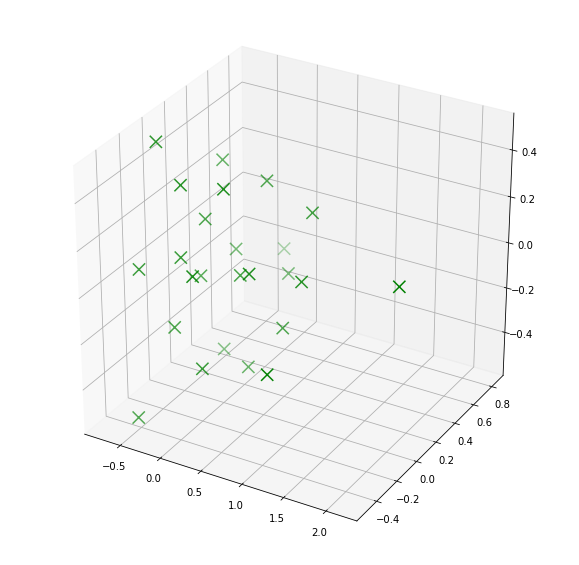

In [82]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

fig = figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.scatter(centroids[:, 0],centroids[:, 1], centroids[:, 2], 
           marker = "x", 
           s=150, 
           linewidths = 5, 
           zorder = 100, 
           c='g')
plt.show()


In [83]:
repos = pd.read_csv('data/new_subset_data/new_subset_repos.csv', sep='\t')
users = pd.read_csv('data/new_subset_data/new_subset_users.csv', sep='\t')
repos = repos.rename(columns={'id':'repo_id', 'owner_id': 'user_id'})
users = users.rename(columns={'id':'user_id'})

In [84]:
repos = repos[['repo_id', 'user_id', 'name']]
users = users[['user_id', 'login']]
joined = repos.merge(users, on=['user_id'])
joined['reponame'] = joined['login'] + '/' + joined['name']
joined = joined[['repo_id', 'reponame']]
joined.head()

,repo_id,reponame
0,10,chapuni/llvm
1,94,chapuni/llvm-project
2,124,chapuni/llvm-project-submodule
3,18689,chapuni/clang
4,40724,chapuni/polly


In [85]:
item_features.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25
0,11,0.281015,0.310938,0.212738,0.322019,0.306467,0.359727,0.320061,0.295764,0.290292,...,0.190681,0.414604,0.263959,0.256662,0.307837,0.329331,0.211287,0.268388,0.358650,0.356613
1,31,0.259998,0.300385,0.145187,0.296630,0.283221,0.352578,0.262828,0.264963,0.250371,...,0.165832,0.440457,0.246546,0.260563,0.261228,0.307279,0.170733,0.237247,0.327649,0.332213
2,61,0.949644,0.097132,0.024802,0.031184,0.008510,0.050240,0.407538,0.197321,0.013332,...,0.797545,0.015498,0.722287,0.602236,0.173145,0.028946,0.010978,0.052181,0.573099,0.089865
3,71,0.266706,0.300834,0.150286,0.293851,0.292492,0.351479,0.252787,0.276408,0.258163,...,0.172232,0.443477,0.251558,0.257181,0.246594,0.315178,0.176462,0.273464,0.361202,0.307029
4,91,0.298433,0.323784,0.167784,0.301080,0.297397,0.363633,0.268437,0.293763,0.293110,...,0.180106,0.466738,0.272873,0.258436,0.291915,0.345561,0.188928,0.289822,0.367143,0.307367


In [86]:
item_features = item_features.merge(joined, left_on='id', right_on='repo_id')
item_features.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f18,f19,f20,f21,f22,f23,f24,f25,repo_id,reponame
0,961,0.261955,0.302291,0.138732,0.283854,0.283704,0.362799,0.276983,0.270742,0.255262,...,0.246316,0.243991,0.250002,0.304008,0.179374,0.274885,0.367936,0.299933,961,ipython/ipython
1,1761,0.172553,0.293395,0.558670,0.975639,1.350090,0.031720,1.145218,0.840646,0.205901,...,1.533070,0.976017,0.069724,0.546007,0.248608,0.484867,0.985100,0.000000,1761,Kimbanjang/Mong2Core
2,3671,0.279241,0.307529,0.149045,0.304127,0.266045,0.333233,0.261118,0.265826,0.272420,...,0.242531,0.197833,0.296783,0.310346,0.196616,0.323173,0.355127,0.259450,3671,NoamB/sorcery
3,3901,0.442554,0.688814,0.191021,0.852400,0.509845,0.819661,0.507312,0.528285,0.556483,...,0.566694,0.436641,0.338590,0.574083,0.397067,0.504255,0.543409,0.633582,3901,sebastyuiop/spree_sale_products
4,4251,0.200009,0.268560,0.246870,0.234839,0.408079,0.362012,0.355213,0.335842,0.206402,...,0.261606,0.267512,0.236988,0.407817,0.254167,0.163199,0.347199,0.279733,4251,phpDocumentor/phpDocumentor2


In [87]:
item_features = item_features.set_index('reponame')

In [11]:
item_features.sort_values('f2', ascending=False)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 963, in start
    self.socket.connect((self.address, self.port))
  File "/home/ubuntu/anaconda2/lib/python2.7/socket.py", line 228, in meth
    return getattr(self._sock,name)(*args)
error: [Errno 111] Connection refused


NameError: name 'item_features' is not defined

In [89]:
itemsLF = item_features.T

In [90]:
itemsLF =itemsLF.sort_index(ascending=False)

In [92]:
itemsLF.head()

reponame,ipython/ipython,Kimbanjang/Mong2Core,NoamB/sorcery,sebastyuiop/spree_sale_products,phpDocumentor/phpDocumentor2,soulwire/SoulwireAS3Framework,azri92/labgeeksrpg,x86ed/cryptocat,alooze/EvoGallery,nunyabidness/color-palette,...,wistful/calibre-recipes,yun313350095/linkhouse,jvanleeuwen/django-react-server-rendering,devimplode/conky-config,achuwilson/Stoolbotics,sk33lz/bearinstalltest,hangyangws/aticle,wert23239/The-Pointlessness-of-Reality,jackluo2012/ECMobile_Universal,coreycoto/PullRequestService
repo_id,961.000000,1761.000000,3671.000000,3901.000000,4251.000000,5881.000000,7121.0,8251.000000,8441.000000,9281.000000,...,6.745880e+07,6.755225e+07,6.765429e+07,6.768678e+07,6.781720e+07,6.784901e+07,6.788999e+07,6.801968e+07,6.812370e+07,6.849289e+07
id,961.000000,1761.000000,3671.000000,3901.000000,4251.000000,5881.000000,7121.0,8251.000000,8441.000000,9281.000000,...,6.745880e+07,6.755225e+07,6.765429e+07,6.768678e+07,6.781720e+07,6.784901e+07,6.788999e+07,6.801968e+07,6.812370e+07,6.849289e+07
f9,0.255262,0.205901,0.272420,0.556483,0.206402,0.358342,0.0,0.331310,0.000000,0.751832,...,5.404958e-01,1.501164e-01,6.251878e-01,5.014739e-01,2.646086e-01,2.481168e-01,3.934491e-01,7.417122e-01,4.210908e-01,2.019843e-01
f8,0.270742,0.840646,0.265826,0.528285,0.335842,0.009475,0.0,0.444112,0.115024,0.814605,...,5.832297e-01,1.823756e-02,9.765778e-02,5.487880e-01,5.170423e-02,2.940652e-01,6.402922e-02,0.000000e+00,4.500561e-01,7.520430e-01
f7,0.276983,1.145218,0.261118,0.507312,0.355213,0.728502,0.0,0.339702,0.673148,0.799718,...,7.499424e-01,4.759499e-02,2.928196e-01,5.302302e-01,7.499307e-01,2.836363e-01,0.000000e+00,0.000000e+00,2.219352e-01,6.179797e-01


In [93]:
itemsLF.to_pickle('data/pickled/latentFeatures.pkl')

# Run model using only stars

In [2]:
stars = pd.read_csv('data/new_subset_data/new_subset_stars.csv', sep='\t')
stars['rating'] = 1.

In [3]:
stars = stars[['user_id', 'repo_id', 'rating']]
stars.head()

,user_id,repo_id,rating
0,421183,992,1.0
1,421183,4077,1.0
2,421183,4654,1.0
3,421183,21985,1.0
4,421183,26647,1.0


In [4]:
sp_stars = spark.createDataFrame(stars)
sp_stars.take(5)

[Row(user_id=421183, repo_id=992, rating=1.0),
 Row(user_id=421183, repo_id=4077, rating=1.0),
 Row(user_id=421183, repo_id=4654, rating=1.0),
 Row(user_id=421183, repo_id=21985, rating=1.0),
 Row(user_id=421183, repo_id=26647, rating=1.0)]

In [5]:
#Change column names to something Spark has hardcoded into their GridSearch feature for dataframes
oldColumns = sp_stars.schema.names
newColumns = ["user", "item", "rating"]

sp_stars = reduce(lambda sp_stars, idx: sp_stars.withColumnRenamed(oldColumns[idx], newColumns[idx]), xrange(len(oldColumns)), sp_stars)
sp_stars.printSchema()

root
 |-- user: long (nullable = true)
 |-- item: long (nullable = true)
 |-- rating: double (nullable = true)



In [16]:
train, test = sp_stars.randomSplit([0.8,0.2],7856)

In [6]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator


In [7]:
als = ALS(nonnegative=True, maxIter=15, regParam=0.1, implicitPrefs=True)

paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [5,10,15,20,25,30,35,40]) \
    .build()
    
crossval = CrossValidator(estimator=als,
                      estimatorParamMaps=paramGrid,
                      evaluator=RegressionEvaluator(
                          metricName="rmse", 
                          labelCol="rating"),
                      numFolds=3)

# Run cross-validation, and choose the best set of parameters.
alsModel = crossval.fit(train)

In [9]:
alsModel.avgMetrics

[nan, nan, nan, nan, nan, nan, nan, nan]

In [10]:
alsModel.bestModel

5

In [35]:
def evaluate_models(trained_models, testdf, metric='rmse'):
    '''
    INPUT: list of trained models, and spark dataframe of training data
    OUTPUT: list of rmses, and list of ranks associated with models
    
    trained_models = [recommender1, recommender2]
    testdf = spark.createDataFrame(test_pandas_df)
    
    rmses, ranks =  evaluate_models(trained_models, testdf)
    '''
    ranks = []
    rmses = []
    for model in trained_models:
        predictions = model.transform(testdf)
        pred_df = predictions.toPandas()
        rawPredictions = spark.createDataFrame(pred_df.dropna(axis=0))
        
        predictions = rawPredictions\
        .withColumn("rating", rawPredictions.rating.cast("double"))\
        .withColumn("prediction", rawPredictions.prediction.cast("double"))
       
        evaluator =\
        RegressionEvaluator(metricName=metric, labelCol="rating", predictionCol="prediction")
        rmse = evaluator.evaluate(predictions)
        
        ranks.append(model.rank)
        rmses.append(rmse)
    return rmses, ranks
    

#### Using only stars did worse than using stars and repo ownership by rank, but this is probably just because of the RMSE metric. If only using stars as implicit the metric should be a binaryclassifier metric (starred or not starred). 

In [13]:
rmses, ranks = evaluate_models([alsModel.bestModel], test, metric='rmse')

In [14]:
rmses

[0.9590361127237246]

In [15]:
ranks

[5]

# Using Number of Commits per Repo

In [37]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator


In [125]:
commits = pd.read_csv('data/new_subset_data/commits_per_repo.csv', sep='\t')

In [126]:
commits.info()
commits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16080124 entries, 0 to 16080123
Data columns (total 3 columns):
repo_id    int64
user_id    int64
commits    int64
dtypes: int64(3)
memory usage: 368.0 MB


,repo_id,user_id,commits
0,1,1,9
1,51746271,1,10
2,56271530,1,15
3,63915386,1,14
4,1,2,48


In [127]:
commits['log_commits'] = np.log(commits['commits'])
commits.tail()

,repo_id,user_id,commits,log_commits
16080119,6630856,36771076,7,1.945910
16080120,67609207,36772705,12,2.484907
16080121,949020,36773439,6,1.791759
16080122,68437586,36774104,7,1.945910
16080123,68434610,36774985,13,2.564949


In [128]:
#commits[['user_id', 'repo_id', 'log_commits']].to_pickle('data/pickled/commits.pkl')

In [129]:
commits = pd.read_pickle('data/pickled/commits.pkl')
commits['log10_commits'] = np.log10(commits['commits'])
commits.head()

,repo_id,user_id,commits,log_commits,log10_commits
0,1,1,9,2.197225,0.954243
1,51746271,1,10,2.302585,1.000000
2,56271530,1,15,2.708050,1.176091
3,63915386,1,14,2.639057,1.146128
4,1,2,48,3.871201,1.681241


In [130]:
commits.to_pickle('data/pickled/commits.pkl')

In [132]:
commits = pd.read_pickle('data/pickled/commits.pkl')
commits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16080124 entries, 0 to 16080123
Data columns (total 5 columns):
repo_id          int64
user_id          int64
commits          int64
log_commits      float64
log10_commits    float64
dtypes: float64(2), int64(3)
memory usage: 613.4 MB


### Just use 100k sample for now

In [98]:
commits = commits.iloc[:1000000,:]
commits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
repo_id          1000000 non-null int64
user_id          1000000 non-null int64
commits          1000000 non-null int64
log_commits      1000000 non-null float64
log10_commits    1000000 non-null float64
dtypes: float64(2), int64(3)
memory usage: 38.1 MB


In [133]:
sp_commits = spark.createDataFrame(commits[['user_id', 'repo_id', 'log10_commits']])

In [134]:
#Change column names to something Spark has hardcoded into their GridSearch feature for dataframes
oldColumns = sp_commits.schema.names
newColumns = ["user", "item", "rating"]

sp_commits = reduce(lambda sp_commits, idx: sp_commits.withColumnRenamed(oldColumns[idx], newColumns[idx]), xrange(len(oldColumns)), sp_commits)
sp_commits.printSchema()

root
 |-- user: long (nullable = true)
 |-- item: long (nullable = true)
 |-- rating: double (nullable = true)



In [101]:
train_commits, test_commits = sp_commits.randomSplit([0.70,0.30],7856)

In [120]:
# Create some models to try
# define models using different ranks
model0 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',    
    regParam=1.0,
    rank=1,
    maxIter=10, 
    implicitPrefs=True,
    alpha=1.0
    ) 

model1 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',   
    regParam=1.0,
    rank=5,
    maxIter=10,
    implicitPrefs=True,
    alpha=1.0
    ) 

model2 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',  
    regParam=1.0,
    rank=7,
    maxIter=10,
    implicitPrefs=True,
    alpha=1.0
    )

model3 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',   
    regParam=1.0,
    rank=10,
    maxIter=10,
    implicitPrefs=True,
    alpha=1.0
    )

model4 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',   
    regParam=1.0,
    rank=15,
    maxIter=10,
    implicitPrefs=True,
    alpha=1.0
    )

model5 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',    
    regParam=1.0,
    rank=20,
    maxIter=10,
    implicitPrefs=True,
    alpha=1.0
    )

model6 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',   
    regParam=1.0,
    rank=25,
    maxIter=10,
    implicitPrefs=True,
    alpha=1.0
    )

model7 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',   
    regParam=1.0,
    rank=30,
    maxIter=10,
    implicitPrefs=True,
    alpha=1.0
    )

model8 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating', 
    regParam=1.0,
    rank=40,
    maxIter=10,
    implicitPrefs=True,
    alpha=1.0
    )

model9 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating', 
    regParam=1.0,
    rank=50,
    maxIter=10,
    implicitPrefs=True,
    alpha=1.0
    )

In [ ]:
# Fit models
recommender0 = model0.fit(train_commits)
recommender1 = model1.fit(train_commits)
recommender2 = model2.fit(train_commits)
recommender3 = model3.fit(train_commits)
recommender4 = model4.fit(train_commits)
recommender5 = model5.fit(train_commits)
recommender6 = model6.fit(train_commits)
recommender7 = model7.fit(train_commits)
recommender8 = model8.fit(train_commits)
recommender9 = model9.fit(train_commits)

models = [recommender0, recommender1, recommender2, recommender3, recommender4, 
          recommender5, recommender6, recommender7, recommender8, recommender9]

In [106]:
rmses, ranks = evaluate_models(models, test_commits, metric='rmse')
rmses_train, ranks_train = evaluate_models(models, train_commits, metric='rmse')

In [107]:
rmses

[1.5613570716223981,
 1.5213964293083964,
 1.5122549011480109,
 1.5012888523134986,
 1.4878400751531402,
 1.476702729974183,
 1.4680919694059782,
 1.4595519744166492,
 1.445161437585388,
 1.4340658315798867]

In [108]:
rmses_train

[1.3842399880456073,
 1.365118959144831,
 1.3589473511128987,
 1.3510299660136673,
 1.3400382000817603,
 1.3306923617536122,
 1.3224512402023454,
 1.3147348692152487,
 1.3011222497606212,
 1.2892660609238882]

In [110]:
import numpy as np

# Using mean rank
predictions_random = recommender0.transform(test_commits) #CHANGE THIS FOR TEST SET

pred_df = predictions_random.toPandas()
mean_rank = np.mean(pred_df.prediction)
pred_df = pred_df.dropna(axis=0)
pred_df['prediction'] = mean_rank

rawPredictions = spark.createDataFrame(pred_df.dropna(axis=0))

predictions = rawPredictions\
.withColumn("rating", rawPredictions.rating.cast("double"))\
.withColumn("prediction", rawPredictions.prediction.cast("double"))

evaluator =\
RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
mean_rmse = evaluator.evaluate(predictions)

print "Model imputed with mean for predictions has RMSE of : {:.4f}".format(mean_rmse)

Model imputed with mean for predictions has RMSE of : 1.5607


# Plot model performances using log commits per repo over several ranks

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

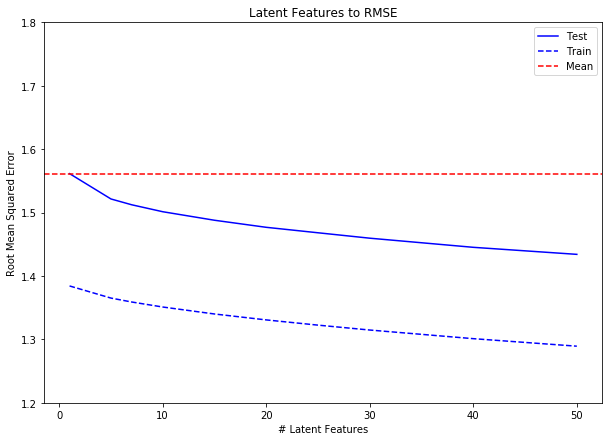

In [119]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.plot(ranks, rmses, label='Test', c='blue')
ax.plot(ranks_train, rmses_train, label='Train', c='blue', ls='dashed')
ax.axhline(mean_rmse, label='Mean', ls='dashed', c='red')

ax.set_title("Latent Features to RMSE")
ax.set_ylabel("Root Mean Squared Error")
ax.set_xlabel("# Latent Features")
ax.set_ylim((1.2,1.8))
ax.legend()
#fig.savefig('/home/ubuntu/PROJECT/github-collaborator/matplots/RMSE.png');

In [114]:
predictions = recommender9.transform(test_commits)
prediction_df = predictions.toPandas()


In [124]:
prediction_df.sort_values('prediction', ascending=False)
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300263 entries, 0 to 300262
Data columns (total 4 columns):
user          300263 non-null int64
item          300263 non-null int64
rating        300263 non-null float64
prediction    56888 non-null float64
dtypes: float64(2), int64(2)
memory usage: 9.2 MB


In [ ]:
def recommend_repos(model, users_df, repos_df, username):
    user = int(users_df['id'].loc[users_df['login'] == username])
    prediction_df = pd.DataFrame(repos_df['id'])
    prediction_df['user'] = user
    prediction_df = prediction_df.rename(columns={'id':'item'})
    
    pred_df = spark.createDataFrame(prediction_df)
    predictions_user = model.transform(pred_df)
    return predictions_user.toPandas().sort_values('prediction', ascending=False).head(10)
    

In [135]:
finalmodel = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating', 
    regParam=50.0,
    rank=55,
    maxIter=20,
    implicitPrefs=True,
    alpha=20.0
    )

In [136]:
final_recommender = finalmodel.fit(sp_commits)

In [137]:
rmses, _ = evaluate_models([final_recommender], test_commits, metric='rmse')


In [138]:
rmses

[1.4049248961465828]

In [139]:
#final_recommender.save('data/models/commitsModel')

In [140]:
final_recommender = ALSModel.load('data/models/commitsModel')

In [1]:
cait_df = pd.DataFrame(commits['repo_id'].unique())
cait_df.head()

NameError: name 'pd' is not defined

In [ ]:
cait_df